In [1]:
# import libraries
import numpy as np
import pandas as pd
import re

# Load and preprocess data

In [2]:
# Load data
data = pd.read_csv('./tpmodel.csv',parse_dates=[0], infer_datetime_format=True)

# Sort headlines by date of publish
data.sort_values('publish_date', inplace=True)

# Retain only alphabets
data['headline_text'] = data['headline_text'].apply(lambda x : re.sub('[^a-zA-Z]', ' ',x))

# Look at the shape of data
print(data.shape)

# Look at the first first five observations
data.head()

(331100, 2)


,publish_date,headline_text
286211,2003-02-19,police defend aboriginal tent embassy raid
180156,2003-02-19,talk of asian nuclear arms race unhelpful downer
233845,2003-02-19,taipans placing future in publics hands
170928,2003-02-19,most highly educated live in nsw wa
245529,2003-02-19,six palestinians killed in gaza incursion


# Which is the most frequently occurring word in the document?

In [3]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english',max_features=30000)

# Transform headlines
news = vectorizer.fit_transform(data['headline_text'])
# print(news)
# initialize empty dictionary
words= {}

# initialize with 0
i=0

# Number of time every feature appears over the entire document
sums = np.array(np.sum(news, axis=0)).flatten()

# Loop to map 'sums' to its word
for word in vectorizer.get_feature_names():
    words[word] = sums[i]
    i += 1

# Top 20 most occuring words
top_20 = sorted(words.items(), key=operator.itemgetter(1), reverse=True)[:20]
print(top_20)

# Display top 20 words
top_20_words = [i[0] for i in top_20]
print(top_20_words)
top_20_values = [i[1] for i in top_20]
print(top_20_values)

[('police', 10752), ('new', 8599), ('man', 8368), ('says', 5987), ('govt', 5048), ('court', 4898), ('council', 4856), ('interview', 4552), ('nsw', 3831), ('australia', 3765), ('plan', 3702), ('water', 3633), ('qld', 3456), ('wa', 3412), ('crash', 3354), ('death', 3338), ('sydney', 3195), ('australian', 3179), ('health', 3118), ('charged', 2993)]
['police', 'new', 'man', 'says', 'govt', 'court', 'council', 'interview', 'nsw', 'australia', 'plan', 'water', 'qld', 'wa', 'crash', 'death', 'sydney', 'australian', 'health', 'charged']
[10752, 8599, 8368, 5987, 5048, 4898, 4856, 4552, 3831, 3765, 3702, 3633, 3456, 3412, 3354, 3338, 3195, 3179, 3118, 2993]


# Topic Modelling with LSA

In [4]:
# import libraries
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
import pprint

# number of topics
n_topics = 5 

# initialize SVD 
lsa_model = TruncatedSVD(n_components=n_topics, random_state=2)

# fit and transform 'news' 
lsa_topic_matrix = lsa_model.fit_transform(news)
print(lsa_topic_matrix.shape)

'''We are not interested in knowing every word of a topic.
Instead, we want to look at the first (lets say) 10 words
of a topic'''

# empty dictionary to store topic number and top 10 words for every topic 
topic_lsa = {}

# loop over every topic
for i, topic in enumerate(lsa_model.components_):
    key = "Topic {}".format(i)
    value = [(vectorizer.get_feature_names()[i] + '*' + str(topic[i])) for i in topic.argsort()[:-11:-1]]
    topic_lsa[key] = ' + '.join(value)
# pretty print topics
pprint.pprint(topic_lsa)

(331100, 5)
{'Topic 0': 'police*0.8601893055234298 + man*0.37687390961080497 + '
            'new*0.1227185188122044 + court*0.0872544186581946 + '
            'charged*0.07895772747439225 + murder*0.07057005753940078 + '
            'car*0.0680006616803336 + crash*0.06584004218944989 + '
            'death*0.06572026639969186 + missing*0.06449235428724628',
 'Topic 1': 'man*0.7879343660154949 + new*0.1921627897748478 + '
            'court*0.18899897199945212 + charged*0.16465801643349426 + '
            'murder*0.09487034753362916 + accused*0.06813694764641615 + '
            'dies*0.06019737315016837 + jailed*0.05319720923467172 + '
            'guilty*0.048466720132486804 + face*0.04514251661316618',
 'Topic 2': 'new*0.935995019854239 + says*0.07749707449614436 + '
            'council*0.0720768218002374 + govt*0.07006061280055194 + '
            'plan*0.042968652525608116 + zealand*0.04093995686187884 + '
            'australia*0.03657006404471675 + laws*0.034839200487652204 + '
 

# Topic Modelling with LDA

In [5]:
# import libraries
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from nltk import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import matplotlib.pyplot as plt

# Function to clean data from stopwords, punctuation marks and lemmatize
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


# Code starts here

# stopwords list
stop = set(stopwords.words('english'))

# string punctuations 
exclude = set(string.punctuation)

# lemmatizer
lemma = WordNetLemmatizer()

# convert headlines to list
headlines = data['headline_text'].tolist()

# cleaned data
clean_headlines = [clean(doc).split() for doc in headlines]

# Creating the term dictionary of our courpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(clean_headlines)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_headlines]

# build LDA model
lda_model = LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, iterations=10, random_state=2)

# extract topics for headlines
topics = lda_model.print_topics(num_topics=5, num_words=10)

# pprint topics
topics

# Code ends here

[(0,
  '0.013*"australia" + 0.011*"south" + 0.011*"adelaide" + 0.009*"election" + 0.009*"first" + 0.008*"new" + 0.008*"council" + 0.008*"open" + 0.008*"take" + 0.007*"turnbull"'),
 (1,
  '0.014*"new" + 0.013*"wa" + 0.013*"nsw" + 0.012*"government" + 0.011*"call" + 0.011*"queensland" + 0.010*"say" + 0.008*"canberra" + 0.008*"sa" + 0.008*"school"'),
 (2,
  '0.017*"man" + 0.016*"police" + 0.015*"woman" + 0.010*"death" + 0.010*"world" + 0.010*"sydney" + 0.008*"perth" + 0.008*"day" + 0.008*"one" + 0.008*"year"'),
 (3,
  '0.017*"trump" + 0.015*"u" + 0.014*"say" + 0.012*"child" + 0.012*"melbourne" + 0.008*"australian" + 0.008*"australia" + 0.007*"donald" + 0.007*"china" + 0.007*"interview"'),
 (4,
  '0.012*"court" + 0.009*"murder" + 0.009*"sex" + 0.008*"market" + 0.008*"family" + 0.008*"change" + 0.007*"help" + 0.007*"australian" + 0.006*"job" + 0.006*"cut"')]

# Coherence score to determine the optimum number of topics

In [8]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_headlines, 
                                     dictionary=dictionary,coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)
# Function to calculate coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = [] 
    for num_topics in range(start,limit,step):
        model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=num_topics, random_state=2,                                                     id2word=dictionary,iterations=10)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts,dictionary=dictionary,coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list,coherence_values
    
# Can take a long time to run
model_list,coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix,texts=clean_headlines, start=2, limit=50, step=6)


0.2817006151285487


# Optimal Number of Topics

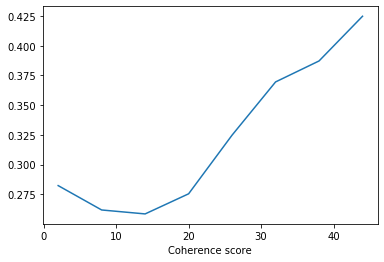

In [9]:
x = np.arange(2,50,6)

# Plotting
plt. plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.xlabel('Coherence score')
plt.show()